In [158]:
%matplotlib widget
import matplotlib.pyplot as plt

In [188]:
from typing import *
import torch
import torch.nn as nn
import functools
import numpy as np


def zeropower_via_svd(G, steps=None, dtype=torch.float32, **kwargs):
    U, S, V = G.to(dtype).svd()
    return (U @ V.T).to(G.dtype)

@torch.compile
def zeropower_via_newtonschulz5(G, steps=5, eps=1e-7, dtype=torch.float32,
                                 abc: torch.Tensor = torch.tensor((3.4445, -4.7750,  2.0315)),
                                 normalize=True):
    r"""
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' \sim Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    assert len(G.shape) == 2
    X = G.to(dtype)
    if normalize:
        X = X / (X.norm() + eps)
    abc = abc.expand(steps, 3).to(G.device, dtype)
    # a, b, c = abc
    if G.size(0) > G.size(1):
        X = X.T
    for a, b, c in zip(*abc.unbind(dim=1)):
        A = X @ X.T
        B = A @ X
        X = a * X + b * B + c * A @ B
    if G.size(0) > G.size(1):
        X = X.T
    return X.to(G.dtype)

def make_schedule(iter5, itermid, iter3):
    abcbad = torch.tensor((3.4445, -4.7750,  2.0315))
    abcgood = torch.tensor((1.5, -0.5, 0))
    abcschedule = torch.cat([
        abcbad.expand(iter5, 3),
        torch.lerp(abcbad, abcgood, torch.linspace(0, 1, itermid + 2)[1:-1, None]),
        abcgood.expand(iter3, 3),
    ], 0)
    return abcschedule


zeropower_backends = dict(
    sgd=lambda g, **kwargs: g,
    sign=lambda g, **kwargs: g.sign(),
    svd=zeropower_via_svd,
    newtonschulz5=zeropower_via_newtonschulz5,
    newtonschulz5_nonorm=functools.partial(zeropower_via_newtonschulz5, normalize=False),
    newtonschulz5_proper=functools.partial(zeropower_via_newtonschulz5, abc=torch.tensor((1.5, -0.5, 0))),
    newtonschulz5_sched5=functools.partial(zeropower_via_newtonschulz5, steps=8, abc=make_schedule(3, 1, 1)),
    newtonschulz5_sched8=functools.partial(zeropower_via_newtonschulz5, steps=8, abc=make_schedule(7, 1, 0)),
    newtonschulz5_sched10=functools.partial(zeropower_via_newtonschulz5, steps=10, abc=make_schedule(8, 1, 1)),
    newtonschulz5_sched14=functools.partial(zeropower_via_newtonschulz5, steps=14, abc=make_schedule(10, 2, 2)),
)


In [277]:
def procedure(W, G, lr=1e-2, backend='svd', norm='analytical'):
    C = W.T @ G
    C_asym = (C - C.T) / 2
    X = zeropower_backends[backend](C_asym)
    A = W @ X
    # print((W.T @ A + A.T @ W).norm(), A.svd().S[0], W.svd().S[0], X.svd().S[0])
    Ap = A * (-lr)
    Wn = W + Ap
    # print((Wn @ Wn.T) / (1 + lr ** 2))
    if norm == 'analytical':
        Wn = Wn / ((1 + lr ** 2) ** 0.5)
    elif norm == 'empirical':
        Wn = Wn * ( min(Wn.shape) **0.5 / (Wn.norm() + 1e-6))
    else:
        raise ValueError(f'Unknown norm: {norm}')
    return Wn


In [126]:
w0 = torch.randn(64, 64)
nn.init.orthogonal_(w0)

tensor([[-0.1450, -0.0011, -0.1479,  ..., -0.0848, -0.0567, -0.1134],
        [ 0.1458, -0.0958,  0.0895,  ...,  0.0275, -0.1275, -0.0975],
        [-0.0471,  0.0498,  0.0062,  ...,  0.0730,  0.2256, -0.0727],
        ...,
        [ 0.0908,  0.2115, -0.0634,  ..., -0.1627,  0.0398, -0.1224],
        [ 0.0697, -0.1838, -0.0036,  ...,  0.0494, -0.0329, -0.1759],
        [-0.0255,  0.0216,  0.3023,  ...,  0.1048, -0.0665,  0.0431]])

In [278]:
w = w0

# backend = 'svd'
backend = 'newtonschulz5'
norm = 'analytical'
# norm = 'empirical'
lr = 1e-1
for ii in range(1000):
    w = procedure(w, torch.randn_like(w), lr=lr, backend=backend, norm=norm)
    if ii % 50 == 0:
        print(f'iter {ii:03d} spectrum:\t', w.svd().S[:5], '...' , w.svd().S[-5:])
    if ii % 50 == 0:
        w = zeropower_backends['newtonschulz5_proper'](w, normalize=False, steps=2)



iter 000 spectrum:	 tensor([1.0016, 1.0016, 1.0014, 1.0014, 1.0014]) ... tensor([0.9974, 0.9973, 0.9973, 0.9952, 0.9952])
iter 050 spectrum:	 tensor([0.9681, 0.9671, 0.9665, 0.9664, 0.9655]) ... tensor([0.9344, 0.9341, 0.9337, 0.9328, 0.9321])
iter 100 spectrum:	 tensor([0.9665, 0.9663, 0.9651, 0.9647, 0.9643]) ... tensor([0.9335, 0.9332, 0.9319, 0.9317, 0.9310])
iter 150 spectrum:	 tensor([0.9682, 0.9667, 0.9664, 0.9657, 0.9652]) ... tensor([0.9331, 0.9328, 0.9327, 0.9323, 0.9314])
iter 200 spectrum:	 tensor([0.9690, 0.9677, 0.9672, 0.9666, 0.9663]) ... tensor([0.9349, 0.9347, 0.9338, 0.9324, 0.9310])
iter 250 spectrum:	 tensor([0.9687, 0.9676, 0.9675, 0.9669, 0.9665]) ... tensor([0.9350, 0.9344, 0.9336, 0.9334, 0.9315])
iter 300 spectrum:	 tensor([0.9690, 0.9675, 0.9666, 0.9655, 0.9653]) ... tensor([0.9339, 0.9338, 0.9333, 0.9320, 0.9313])
iter 350 spectrum:	 tensor([0.9685, 0.9680, 0.9670, 0.9661, 0.9660]) ... tensor([0.9347, 0.9339, 0.9334, 0.9325, 0.9323])
iter 400 spectrum:	 tens

In [166]:
(zeropower_backends['newtonschulz5_nonorm'](w, steps=7) + zeropower_backends['newtonschulz5_nonorm'](w, steps=8)).div(2).svd().S


tensor([0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081,
        0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081,
        0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.9081,
        0.9081, 0.9081, 0.9081, 0.9081, 0.9081, 0.8999, 0.8999, 0.8999, 0.8999,
        0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999,
        0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999,
        0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999, 0.8999,
        0.8999])

In [171]:
Ss.shape

torch.Size([10, 12])

In [185]:
Ss.mean(0)

tensor([0.0849, 0.2858, 0.7689, 0.8511, 0.8932, 0.8682, 0.8967, 0.8805, 0.9186,
        0.8869, 0.9198, 0.8824, 0.9250, 0.8894, 0.9234, 0.8820, 0.9239, 0.8893,
        0.9236, 0.8817])

W1112 15:50:36.957000 43931 site-packages/torch/_dynamo/convert_frame.py:844] [2/8] torch._dynamo hit config.cache_size_limit (8)
W1112 15:50:36.957000 43931 site-packages/torch/_dynamo/convert_frame.py:844] [2/8]    function: 'zeropower_via_newtonschulz5' (/var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_43931/168046937.py:12)
W1112 15:50:36.957000 43931 site-packages/torch/_dynamo/convert_frame.py:844] [2/8]    last reason: 2/0: L['steps'] == 0                                             
W1112 15:50:36.957000 43931 site-packages/torch/_dynamo/convert_frame.py:844] [2/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1112 15:50:36.957000 43931 site-packages/torch/_dynamo/convert_frame.py:844] [2/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
/var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_43931/1100820078.py:12: UserWarning: No artists with labels found to put in legend.  Note that arti

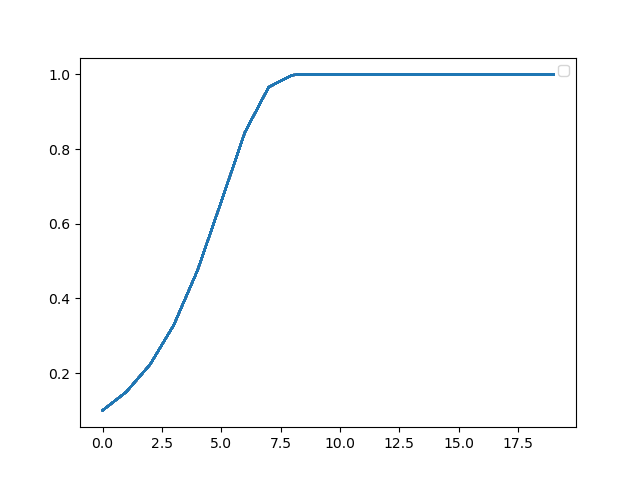

In [189]:
plt.close('all')
w0 = torch.eye(100)
# w0 = torch.randn_like(w0)
nn.init.orthogonal_(w0)
Ss = []
for steps in range(20):
    Ss.append(zeropower_backends['newtonschulz5_proper'](w0, steps=steps).svd().S)

Ss = torch.stack(Ss, -1)

plt.plot(Ss.T, color='C0', alpha=0.2)
plt.legend()
plt.show()


In [505]:
class OrthOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-2, backend='svd', norm='analytical', reproj_interval=50, reproj_fn=None,
                 nesterov=True, momentum=0.9):
        defaults = dict(lr=lr, backend=backend, norm=norm, reproj_interval=reproj_interval, reproj_fn=reproj_fn,
                        nesterov=nesterov, momentum=momentum)
        super().__init__(params, defaults)

    def _apply_momentum(self, state, x: torch.Tensor, momentum, *, is_nesterov, prefix: str):
        # m = beta1 * m + g
        # g = g + m * beta1
        # ----
        # equiv:
        # g = g + beta1**2 * m + beta1 * g
        #   = (1+beta1) g + beta1**2 m
        if momentum == 0:
            return x
        if f'{prefix}_momentum_buffer' not in state:
            state[f'{prefix}_momentum_buffer'] = torch.zeros_like(x)
        buf = state[f'{prefix}_momentum_buffer']
        if is_nesterov:
            buf.mul_(momentum).add_(x)
            return x.add(buf, alpha=momentum)
        else:
            torch.lerp(buf, x, 1 - momentum, out=buf)
            return buf / (1 - momentum ** state['stept'])

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                if grad is None:
                    continue
                state = self.state[p]

                if 'stept' not in state:
                    state['stept'] = 0
                state['stept'] += 1
                stept = state['stept']

                update = self._apply_momentum(
                    state, grad, group['momentum'], is_nesterov=group['nesterov'], prefix='update')

                scale_factor = (p.data.shape[0] / p.data.shape[1]) ** 0.5

                p.data.copy_(
                    procedure(p.data / scale_factor,
                              update,
                            #   update * scale_factor,  scaling doesn't matter for this update rule
                              lr=group['lr'], backend=group['backend'], norm=group['norm'])
                    * scale_factor
                )

                if stept % group['reproj_interval'] == 0 and (reproj_fn := group['reproj_fn']) is not None:
                    p.data.copy_(reproj_fn(p.data / scale_factor) * scale_factor)

In [517]:
class Mul(nn.Module):
    def __init__(self, scale, learnable=False):
        super().__init__()
        if learnable:
            self.scale = nn.Parameter(torch.tensor(scale, dtype=torch.float32))
        else:
            self.register_buffer('scale', torch.tensor(scale, dtype=torch.float32))

    def forward(self, x):
        return x * self.scale

def make_model(add_relu_scale=True, final_scale_fn=nn.Identity):
    model = nn.Sequential(
        nn.Linear(28*28, 28*28),
        nn.ReLU(),
        Mul(np.sqrt(2)) if add_relu_scale else nn.Identity(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        Mul(np.sqrt(2)) if add_relu_scale else nn.Identity(),
        nn.Linear(256, 256),
        nn.ReLU(),
        Mul(np.sqrt(2)) if add_relu_scale else nn.Identity(),
        nn.Linear(256, 256),
        nn.ReLU(),
        Mul(np.sqrt(2)) if add_relu_scale else nn.Identity(),
        nn.Linear(256, 64),
        nn.ReLU(),
        Mul(np.sqrt(2)) if add_relu_scale else nn.Identity(),
        nn.Linear(64, 10),
        final_scale_fn(),
    ).to(torch.float32)

    model = orth_init(model)
    model = torch.compile(model)
    return model


def orth_init(model):
    import torch.nn as nn
    @torch.no_grad()
    def init(m):
        if isinstance(m, nn.Linear):
            fan_out = m.weight.size(0)
            fan_in = m.weight.size(1)
            dtype = m.weight.dtype
            m.to(torch.float32)
            nn.init.orthogonal_(m.weight)
            m.weight.mul_(
                (fan_out / fan_in) ** 0.5
            )
            if m.bias is not None:
                nn.init.zeros_(m.bias)
            m.to(dtype)
    model.apply(init)
    return model

def make_optimizers(model, lr, **kwargs):
    return [
        OrthOptimizer([p for p in model.parameters() if p.ndim == 2], lr=lr, **kwargs),
        torch.optim.Adam([p for p in model.parameters() if p.ndim != 2], lr=lr),
    ]



In [513]:
model = make_model(add_relu_scale=True, add_final_scale=False)
optims = make_optimizers(model, lr=2e-2, backend='newtonschulz5', norm='analytical', reproj_interval=10,
                         nesterov=False,
                        #  reproj_fn=lambda w: (
                        #      zeropower_backends['newtonschulz5_proper'](w, normalize=False, steps=1)
                        #  ),
                         )
# optims = [
#     torch.optim.Adam(model.parameters(), lr=8e-3)
# ]


In [518]:
# mnist training loop

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=2048, shuffle=True, drop_last=True)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=4096, shuffle=False)


def eval_model(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device).flatten(1), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(loader.dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, optims, train_loader, test_loader, epochs=20):
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device).flatten(1), target.to(device)
            [optim.zero_grad() for optim in optims]
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            [optim.step() for optim in optims]
            if batch_idx % 20 == 0:
                print(f'epoch {epoch:02d} batch {batch_idx:03d} loss: {loss.item():.4f}')
        print(f'epoch {epoch:02d} test acc: {eval_model(model, test_loader):.2%}')

    train_acc, test_acc = eval_model(model, train_loader), eval_model(model, test_loader)
    print(f'final train acc: {train_acc:.2%} test acc: {test_acc:.2%}')
    return train_acc, test_acc




In [534]:
final_scales = torch.logspace(-3, 1, 5)

In [535]:
lrs = torch.logspace(-3, 1, 5)

In [536]:
lrs

tensor([1.0000e-03, 1.0000e-02, 1.0000e-01, 1.0000e+00, 1.0000e+01])

In [538]:
from tqdm.auto import tqdm

train_accs = torch.zeros(len(final_scales), len(lrs))
test_accs = torch.zeros(len(final_scales), len(lrs))
sds = [[] for _ in range(len(final_scales))]

for i, final_scale in enumerate(tqdm(final_scales)):
    for j, lr in enumerate(lrs):
        model = make_model(add_relu_scale=True, final_scale_fn=lambda: Mul(final_scale))
        optims = make_optimizers(model, lr=lr, backend='newtonschulz5', norm='analytical', reproj_interval=10,
                             nesterov=False, reproj_fn=None,
                            #  reproj_fn=lambda w: (
                            #      zeropower_backends['newtonschulz5_proper'](w, normalize=False, steps=1)
                            #  ),
                         )
        train_acc, test_acc = train_model(model, optims, train_loader, test_loader, epochs=10)
        train_accs[i, j] = train_acc
        test_accs[i, j] = test_acc
        sds[i].append(model.state_dict())

  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/ky/gxqpxwvx29ggdsqzf67zslfh0000gn/T/ipykernel_43931/1450525735.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('scale', torch.tensor(scale, dtype=torch.float32))


epoch 00 batch 000 loss: 2.3026
epoch 00 batch 020 loss: 2.3025
epoch 00 test acc: 28.98%
epoch 01 batch 000 loss: 2.3025
epoch 01 batch 020 loss: 2.3024
epoch 01 test acc: 45.42%
epoch 02 batch 000 loss: 2.3024
epoch 02 batch 020 loss: 2.3023
epoch 02 test acc: 54.45%
epoch 03 batch 000 loss: 2.3022
epoch 03 batch 020 loss: 2.3021
epoch 03 test acc: 59.86%
epoch 04 batch 000 loss: 2.3021
epoch 04 batch 020 loss: 2.3019
epoch 04 test acc: 63.09%
epoch 05 batch 000 loss: 2.3018
epoch 05 batch 020 loss: 2.3016
epoch 05 test acc: 65.43%
epoch 06 batch 000 loss: 2.3016
epoch 06 batch 020 loss: 2.3014
epoch 06 test acc: 67.17%
epoch 07 batch 000 loss: 2.3013
epoch 07 batch 020 loss: 2.3011
epoch 07 test acc: 68.17%
epoch 08 batch 000 loss: 2.3010


KeyboardInterrupt: 

In [526]:
final_scales

tensor([1.0000e-04, 2.6367e-04, 6.9519e-04, 1.8330e-03, 4.8329e-03, 1.2743e-02,
        3.3598e-02, 8.8587e-02, 2.3357e-01, 6.1585e-01, 1.6238e+00, 4.2813e+00,
        1.1288e+01, 2.9764e+01, 7.8476e+01, 2.0691e+02, 5.4556e+02, 1.4384e+03,
        3.7927e+03, 1.0000e+04])

In [473]:
eval_model(model, train_loader)

0.9548

In [490]:
data.flatten(1).pow(2).mean(-1).sqrt().sort().values

tensor([0.6016, 0.6017, 0.6051,  ..., 1.4760, 1.4932, 1.5472])

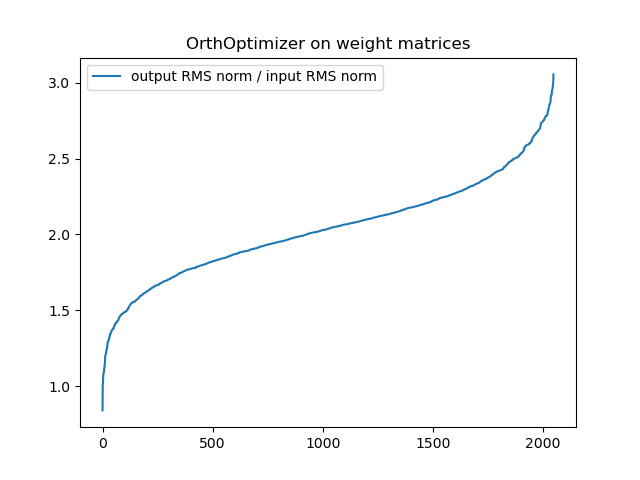

In [516]:
plt.close('all')
plt.plot((
    (output).pow(2).mean(-1).sqrt().data /
    data.flatten(1).pow(2).mean(-1).sqrt()
).sort().values, label='output RMS norm / input RMS norm')
# plt.plot((output / model._orig_mod[-1].scale).pow(2).mean(-1).sqrt().sort().values.data, label='output RMS norm')
# # plt.axhline(1, color='red', lw=0.5, ls='--')
# plt.plot((output / model._orig_mod[-1].scale).softmax(-1).max(-1).values.sort().values.data, label='output prob max')
plt.title('OrthOptimizer on weight matrices')
plt.legend()
plt.show()


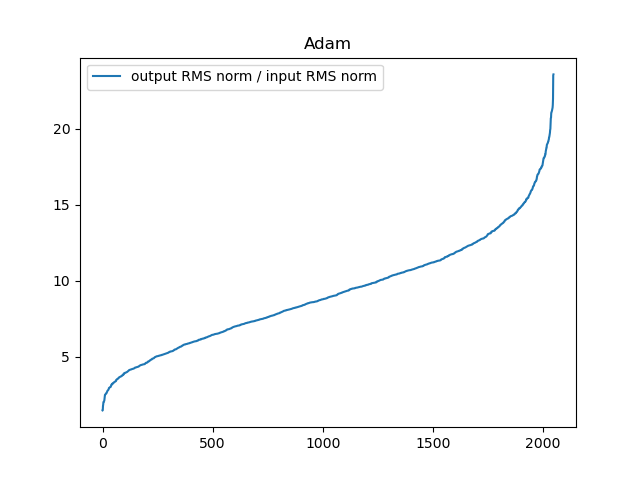

In [502]:
plt.close('all')
plt.plot((
    (output).pow(2).mean(-1).sqrt().data /
    data.flatten(1).pow(2).mean(-1).sqrt()
).sort().values, label='output RMS norm / input RMS norm')
# plt.plot((output / model._orig_mod[-1].scale).pow(2).mean(-1).sqrt().sort().values.data, label='output RMS norm')
# # plt.axhline(1, color='red', lw=0.5, ls='--')
# plt.plot((output / model._orig_mod[-1].scale).softmax(-1).max(-1).values.sort().values.data, label='output prob max')

plt.title('Adam')
plt.legend()
plt.show()


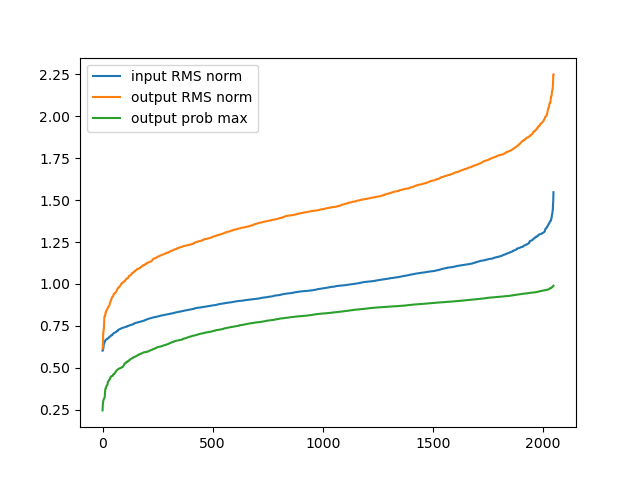

In [492]:
plt.close('all')
plt.plot(data.flatten(1).pow(2).mean(-1).sqrt().sort().values, label='input RMS norm')
plt.plot((output / model._orig_mod[-1].scale).pow(2).mean(-1).sqrt().sort().values.data, label='output RMS norm')
# plt.axhline(1, color='red', lw=0.5, ls='--')
plt.plot((output / model._orig_mod[-1].scale).softmax(-1).max(-1).values.sort().values.data, label='output prob max')
plt.legend()
plt.show()


In [487]:
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Mul()
    (3): Linear(in_features=784, out_features=256, bias=True)
    (4): ReLU()
    (5): Mul()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Mul()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Mul()
    (12): Linear(in_features=256, out_features=64, bias=True)
    (13): ReLU()
    (14): Mul()
    (15): Linear(in_features=64, out_features=10, bias=True)
    (16): Mul()
  )
)

In [486]:
for name, param in model.named_parameters():
    if param.ndim != 2:
        continue
    fan_out, fan_in = param.data.shape
    spectrum = param.data.svd().S
    spectral_norm = spectrum[0]
    opnorm = (fan_in / fan_out) ** 0.5 * spectral_norm
    name = name.split('.', 1)[1]
    print(f"W={repr(name):15s}", f'rms-to-rms_op_norm={opnorm.item():.4f}  ', f'stddev( SVD(W).S )={spectrum.std().item():.2e}')



W='0.weight'      rms-to-rms_op_norm=0.9974   stddev( SVD(W).S )=3.44e-03
W='3.weight'      rms-to-rms_op_norm=0.9980   stddev( SVD(W).S )=1.09e-03
W='6.weight'      rms-to-rms_op_norm=1.0005   stddev( SVD(W).S )=2.81e-03
W='9.weight'      rms-to-rms_op_norm=1.0022   stddev( SVD(W).S )=4.21e-03
W='12.weight'     rms-to-rms_op_norm=0.9993   stddev( SVD(W).S )=2.58e-03
W='15.weight'     rms-to-rms_op_norm=0.9984   stddev( SVD(W).S )=1.62e-03


In [488]:
model._orig_mod[-1].scale

Parameter containing:
tensor(2.4970, requires_grad=True)